In [19]:
!pip install -q kaggle
!kaggle datasets download -d joebeachcapital/realwaste
!unzip realwaste.zip


Dataset URL: https://www.kaggle.com/datasets/joebeachcapital/realwaste
License(s): Attribution 4.0 International (CC BY 4.0)
realwaste.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  realwaste.zip
replace realwaste-main/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [20]:
import tensorflow as tf

# Menampilkan perangkat yang tersedia (CPU dan GPU)
print("Available devices:")
print(tf.config.list_physical_devices())

# Mengecek apakah GPU tersedia
if tf.config.list_physical_devices('GPU'):
    print("Training menggunakan GPU!")
else:
    print("Training menggunakan CPU.")

Available devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Training menggunakan GPU!


# **Import data & siapkan tools**

In [21]:
data_dir = "/content/realwaste-main/RealWaste"

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Pilih Class

disini saya hanya menggunakan 4 dari 9 class

In [23]:
import os
import shutil

# Path ke dataset asli
data_dir = "/content/realwaste-main/RealWaste"

# Kelas yang akan digunakan
selected_classes = ["Cardboard", "Glass", "Plastic", "Vegetation"]

# Path untuk folder dataset baru
target_dir = "./filtered_dataset"
os.makedirs(target_dir, exist_ok=True)

# Salin hanya kelas yang dipilih ke folder baru
for class_name in selected_classes:
    class_path = os.path.join(data_dir, class_name)
    target_class_path = os.path.join(target_dir, class_name)
    os.makedirs(target_class_path, exist_ok=True)

    # Periksa apakah folder kelas ada
    if not os.path.exists(class_path):
        print(f"Folder tidak ditemukan untuk kelas: {class_name}, lewati...")
        continue

    # Salin file dari kelas ke folder target
    for file_name in os.listdir(class_path):
        source_file = os.path.join(class_path, file_name)
        target_file = os.path.join(target_class_path, file_name)
        shutil.copy(source_file, target_file)

print("Data berhasil difilter ke 4 kelas.")

Data berhasil difilter ke 4 kelas.


## ImageDataGenerator untuk augmentasi dan normalisasi

In [24]:
# Parameter
target_size = (224, 224)
image_channel = 3
batch_size = 32
image_size = 224

train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalisasi pixel ke [0, 1]
    validation_split=0.2,        # 20% untuk validasi
    rotation_range=30,           # Rotasi gambar hingga 30 derajat
    width_shift_range=0.2,       # Pergeseran horizontal hingga 20%
    height_shift_range=0.2,      # Pergeseran vertikal hingga 20%
    shear_range=0.2,             # Distorsi shearing hingga 20%
    zoom_range=0.2,              # Zoom in/out hingga 20%
    horizontal_flip=True,        # Membalik gambar secara horizontal
    brightness_range=[0.8, 1.2]  # Variasi kecerahan
)

# Data validasi hanya rescale tanpa augmentasi
test_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalisasi pixel ke [0, 1]
    validation_split=0.2         # Sama seperti training untuk validasi
)

## Apply pada data test dan train

In [25]:
# Dataset untuk training
train_data = train_datagen.flow_from_directory(
    directory=target_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

# Dataset untuk validasi
test_data = test_datagen.flow_from_directory(
    directory=target_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)

Found 1791 images belonging to 4 classes.
Found 447 images belonging to 4 classes.


## Membuat fungsi `get_callbacks()`

Kode ini adalah sebuah fungsi Python bernama get_callbacks() yang mengembalikan daftar callback untuk digunakan saat melatih model machine learning menggunakan Keras (atau TensorFlow). Callbacks adalah mekanisme untuk memantau pelatihan model dan mengatur prosesnya, seperti menyimpan model terbaik, menghentikan pelatihan lebih awal, atau menyesuaikan parameter pelatihan.

In [26]:
def get_callbacks():
    # Menyimpan model terbaik berdasarkan akurasi validasi
    checkpoint = ModelCheckpoint(
        'best_model.keras',  # Ubah ekstensi file menjadi .keras
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    # Menghentikan pelatihan lebih awal jika akurasi validasi tidak meningkat
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min',
        verbose=1
    )

    # Mengurangi learning rate jika tidak ada peningkatan pada loss validasi
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )

    return [checkpoint, early_stopping, reduce_lr]

## Modelling

In [27]:
import random

# Set the seed values
seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

# Model definition
def model_5():
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=[image_size, image_size, image_channel], padding='same'))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model_coba = model_5()
model_coba.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 74, 74, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 74, 74, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 24, 24, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │         262,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │          33,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 451,876 (1.72 MB)

 Trainable params: 451,652 (1.72 MB)

 Non-trainable params: 224 (896.00 B)

## Fit model

In [28]:
# history_coba = model_coba.fit(train_data,
#                                     epochs=30,
#                                     validation_data=test_data,
#                                     verbose=1,
#                                     callbacks=get_callbacks(),
#                                     batch_size=batch_size)
# test_loss, test_acc = model_coba.evaluate(test_data, verbose=2)
# print('\nTest accuracy:', test_acc)

In [29]:
def display_metrik(history, figure_name):

    train = history.history[f'{figure_name}']
    val = history.history[f'val_{figure_name}']

    epochs = range(1, len(train) + 1)
    plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')
    plt.plot(epochs, val, 'b', label=f'Validation {figure_name}')
    plt.title(f'Training and Validation {figure_name}')
    plt.xlabel('Epochs')
    plt.ylabel(f'{figure_name}')
    plt.legend()
    plt.show()

In [30]:
# # Menampilkan loss
# display_metrik(history_coba, 'loss')

# # Menampilkan akurasi
# display_metrik(history_coba, 'accuracy')

Hasil dari model 1 kureng, jadi saya tidak menampilkannya

## Percobaan model 2

In [37]:
# Set seed values
seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

def create_cnn_model(input_shape=(224, 224, 3), num_classes=4):
    model = Sequential()

    # Convolution and Pooling layers
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))  # Dropout after the first convolutional layer

    # Second Convolution layer
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))  # Dropout after the second convolutional layer

    # Third Convolution layer
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))  # Dropout after the third convolutional layer

    # Flatten the output of the convolution layers
    model.add(Flatten())

    # Fully connected (Dense) layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Dropout after the first dense layer
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))  # Multi-class classification

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [42]:
# Membuat model
model_cnn = create_cnn_model(input_shape=(224, 224, 3), num_classes=4)

# Melatih model
history_cnn = model_cnn.fit(
    train_data,
    epochs=30,
    validation_data=test_data,
    callbacks=get_callbacks()  # Callbacks untuk memonitor pelatihan
)

# Evaluasi model
test_loss, test_acc = model_cnn.evaluate(test_data, verbose=2)
print(f'\nTest Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.3538 - loss: 2.0585
Epoch 1: val_accuracy improved from -inf to 0.41163, saving model to best_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 47s 670ms/step - accuracy: 0.3544 - loss: 2.0497 - val_accuracy: 0.4116 - val_loss: 1.3533 - learning_rate: 0.0010
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.3983 - loss: 1.3267
Epoch 2: val_accuracy did not improve from 0.41163
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 509ms/step - accuracy: 0.3985 - loss: 1.3265 - val_accuracy: 0.4116 - val_loss: 1.3098 - learning_rate: 0.0010
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.4333 - loss: 1.2279
Epoch 3: val_accuracy did not improve from 0.41163
56/56 ━━━━━━━━━━━━━━━━━━━━ 33s 513ms/step - accuracy: 0.4334 - loss: 1.2281 - val_accuracy: 0.2953 - val_loss: 1.2913 - learning_rate: 0.0010
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.4649 - loss: 1.2207
Epoch 4: val_accuracy improved from 0.4116

## Buat Evaluasi Model

In [33]:
def display_metrik(history, figure_name):

    train = history.history[f'{figure_name}']
    val = history.history[f'val_{figure_name}']

    epochs = range(1, len(train) + 1)
    plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')
    plt.plot(epochs, val, 'b', label=f'Validation {figure_name}')
    plt.title(f'Training and Validation {figure_name}')
    plt.xlabel('Epochs')
    plt.ylabel(f'{figure_name}')
    plt.legend()
    plt.show()

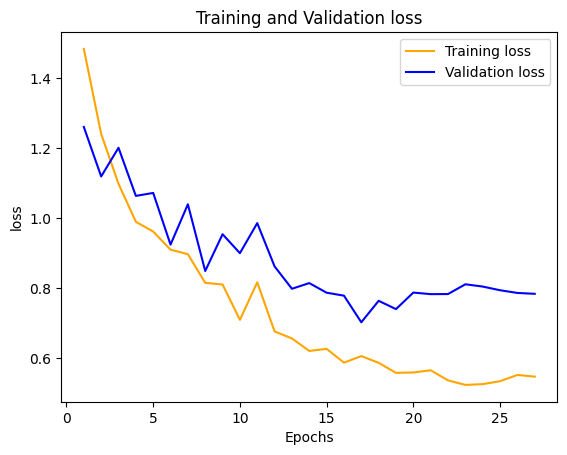

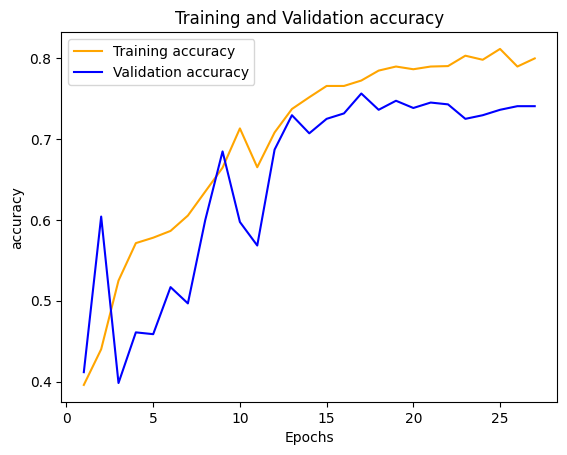

In [34]:
# Menampilkan loss
display_metrik(history_cnn, 'loss')

# Menampilkan akurasi
display_metrik(history_cnn, 'accuracy')


## Deploy Model

In [35]:
! pip install gradio

In [36]:
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image

# Load the updated model
model = load_model("best_model.keras")

# Update class names
CLASS_NAMES = ["Cardboard", "Glass", "Plastic", "Vegetation"]

def predict_image(image):
    # Preprocess the image
    img = Image.fromarray(image).resize((224, 224))
    img_array = np.array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make prediction
    predictions = model.predict(img_array)
    confidences = {CLASS_NAMES[i]: float(predictions[0][i]) for i in range(len(CLASS_NAMES))}

    return confidences

# Create Gradio interface
demo = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(),
    outputs=gr.Label(num_top_classes=4),
    title="Image Classification Demo",
    description="Upload an image and the model will classify it into one of the following categories: " + ", ".join(CLASS_NAMES),
    examples=[
        ["example1.jpg"],
        ["example2.jpg"]
    ]  # Optional: Add example images
)

demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://efa16fe197265e3fdd.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
